### Import required libraries

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

### Load Data 


In [34]:
# parse the labels

def parse_labels(label_file_path):
    data = []
    with open(label_file_path, 'r') as f:
        f.readline() # first line is header
        for line in f:
            gene_id, transcript_id, position, label = line.strip().split(',')
            data.append({
                'gene_id': gene_id,
                'transcript_id': transcript_id,
                'position': int(position),
                'label': int(label)
            })
    return pd.DataFrame(data)

label_df = parse_labels("data_info_labelled")
#label_df = pd.read_csv('labels.csv')

#print(label_df.head())

In [19]:
# parse the features

def parse_features(feature_file_path):
    rows = []

    with open(feature_file_path, 'r') as file:
        for line in file:
            data = json.loads(line)

            for transcript_id, positions in data.items():
                for position, flanking_data in positions.items():
                    for flanking_nucleotide, features_list in flanking_data.items():
                        for features in features_list:
                            row = {
                                "transcript_id": transcript_id,
                                "position": int(position),
                                "flanking_nucleotide": flanking_nucleotide,
                                "dwelling_time_(-1)": features[0],
                                "std_dev_(-1)": features[1],
                                "mean_signal_(-1)": features[2],
                                "dwelling_time_central": features[3],
                                "std_dev_central": features[4],
                                "mean_signal_central": features[5],
                                "dwelling_time_(+1)": features[6],
                                "std_dev_(+1)": features[7],
                                "mean_signal_(+1)": features[8]
                            }
                            rows.append(row)  # Append each parsed entry to rows

    return pd.DataFrame(rows)

# features_df = parse_features("../data/dataset0.json.gz")
features_df = pd.read_csv("parsed_data.csv")

#print(features_df.head())

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA             0.00299   
1  ENST00000000233       244             AAGACCA             0.00631   
2  ENST00000000233       244             AAGACCA             0.00465   
3  ENST00000000233       244             AAGACCA             0.00398   
4  ENST00000000233       244             AAGACCA             0.00664   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0          2.06             125.0                0.01770            10.40   
1          2.53             125.0                0.00844             4.67   
2          3.92             109.0                0.01360            12.00   
3          2.06             125.0                0.00830             5.01   
4          2.92             120.0                0.00266             3.94   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  
0                122.0     

### Train test split


In [20]:
# split by genes
unique_genes = label_df['gene_id'].unique()
train_genes, test_genes = train_test_split(unique_genes, test_size=0.2, random_state=49)

# split transcripts based on genes
train_transcript = label_df[label_df['gene_id'].isin(train_genes)]["transcript_id"]
test_transcript = label_df[label_df['gene_id'].isin(test_genes)]["transcript_id"]
train_df = features_df[features_df['transcript_id'].isin(train_transcript)]
test_df = features_df[features_df['transcript_id'].isin(test_transcript)]

#print(train_df.head())
#print(test_df.head())
print(len(train_df))
print(len(test_df))

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA             0.00299   
1  ENST00000000233       244             AAGACCA             0.00631   
2  ENST00000000233       244             AAGACCA             0.00465   
3  ENST00000000233       244             AAGACCA             0.00398   
4  ENST00000000233       244             AAGACCA             0.00664   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0          2.06             125.0                0.01770            10.40   
1          2.53             125.0                0.00844             4.67   
2          3.92             109.0                0.01360            12.00   
3          2.06             125.0                0.00830             5.01   
4          2.92             120.0                0.00266             3.94   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  
0                122.0     

### Combine reads

In [21]:
# combine reads using weighted average

def weighted_combine_reads(df):
    def weighted_avg(group, value_col, weight_col):
        d = group[value_col]
        w = 1 / (group[weight_col] ** 2)
        if w.sum() == 0:
            return float('nan')
        return (d * w).sum() / w.sum()

    grouped = df.groupby(['transcript_id', 'position', 'flanking_nucleotide'])
    combined_df = grouped.apply(
        lambda group: pd.Series({
            'dwelling_time_(-1)': weighted_avg(group, 'dwelling_time_(-1)', 'std_dev_(-1)'),
            'mean_signal_(-1)': weighted_avg(group, 'mean_signal_(-1)', 'std_dev_(-1)'),
            'mean_range_(-1)': max(group['mean_signal_(-1)']) - min(group['mean_signal_(-1)']),
            'dwelling_time_central': weighted_avg(group, 'dwelling_time_central', 'std_dev_central'),
            'mean_signal_central': weighted_avg(group, 'mean_signal_central', 'std_dev_central'),
            'mean_range_central': max(group['mean_signal_central']) - min(group['mean_signal_central']),
            'dwelling_time_(+1)': weighted_avg(group, 'dwelling_time_(+1)', 'std_dev_(+1)'),
            'mean_signal_(+1)': weighted_avg(group, 'mean_signal_(+1)', 'std_dev_(+1)'),
            'mean_range_(+1)': max(group['mean_signal_(+1)']) - min(group['mean_signal_(+1)'])
        }), include_groups=False
    ).reset_index()

    # Explicitly include grouping columns to avoid warnings
    combined_df = combined_df[['transcript_id', 'position', 'flanking_nucleotide', 
                               'dwelling_time_(-1)', 'mean_signal_(-1)', 'mean_range_(-1)', 
                               'dwelling_time_central', 'mean_signal_central', 'mean_range_central', 
                               'dwelling_time_(+1)', 'mean_signal_(+1)', 'mean_range_(+1)']]

    return combined_df

train_combined_weighted = weighted_combine_reads(train_df)
test_combined_weighted = weighted_combine_reads(test_df)

In [22]:
# combine reads using average

def combine_reads(df):
    return df.groupby(['transcript_id', 'position', 'flanking_nucleotide']).mean().reset_index()

train_combined = combine_reads(train_df)
test_combined = combine_reads(test_df)

In [23]:
# merge data with labels
train_labelled = pd.merge(train_combined, label_df[['transcript_id', 'position', 'label']], 
                     on=['transcript_id', 'position'], 
                     how='left')

test_labelled = pd.merge(test_combined, label_df[['transcript_id', 'position', 'label']],
                    on=['transcript_id', 'position'],
                    how='left')

#print(train_labelled.head())
#print(test_labelled.head())

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA            0.008264   
1  ENST00000000233       261             CAAACTG            0.006609   
2  ENST00000000233       316             GAAACAG            0.007570   
3  ENST00000000233       332             AGAACAT            0.010620   
4  ENST00000000233       368             AGGACAA            0.010701   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0      4.223784        123.702703               0.009373         7.382162   
1      3.216424        109.681395               0.006813         3.226535   
2      2.940541        105.475676               0.007416         3.642703   
3      6.476350        129.355000               0.008632         2.899200   
4      6.415051        117.924242               0.011479         5.870303   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  \
0           125.913514    

### Oversampling

I use random oversampling here instead of SMOTE because it could generate synthetic transcript IDs and positions, which are not valid.


In [35]:
## find average of each position

averaged_train_df = train_labelled.groupby(['transcript_id', 'position','flanking_nucleotide']).mean().reset_index()

# Display the resulting DataFrame
#print(averaged_train_df.head())

print(len(averaged_train_df))
sum(averaged_train_df['label'] == 1)

4859


207

In [25]:
X = averaged_train_df.drop('label', axis=1)  # Features
y = averaged_train_df['label']               # Target (label)

# Define the oversampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the resampled features and labels into a new DataFrame
resampled_train_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

# Display the new shape of the resampled dataset
print(len(resampled_train_df))

9304


### Feature Engineering

#### Normalization

In [37]:
# Initialize the StandardScaler
scaler = StandardScaler()

'''
# weighted avg combined reads
numeric_columns = ['dwelling_time_(-1)', 'mean_signal_(-1)', 'mean_range_(-1)',
                   'dwelling_time_central', 'mean_signal_central', 'mean_range_central',
                   'dwelling_time_(+1)', 'mean_signal_(+1)', 'mean_range_(+1)']
'''

# avg combined reads
numeric_columns = ['dwelling_time_(-1)', 'std_dev_(-1)', 'mean_signal_(-1)',
                   'dwelling_time_central', 'std_dev_central', 'mean_signal_central',
                   'dwelling_time_(+1)', 'std_dev_(+1)', 'mean_signal_(+1)']

# scale the numeric columns of train and test data
standardized_train_df = resampled_train_df.copy()
standardized_train_df[numeric_columns] = scaler.fit_transform(resampled_train_df[numeric_columns])

standardized_test_df = test_labelled.copy()
standardized_test_df[numeric_columns] = scaler.fit_transform(test_labelled[numeric_columns])

# View the standardized dataset
#print(standardized_train_df.head())
#print(standardized_test_df.head())

In [42]:
# save inputs file
# standardized_train_df.to_csv('../data/train_avg.csv', index=False)
# standardized_test_df.to_csv('../data/test_avg.csv', index=False)

## Model Training

In [58]:
# inputs
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# train = pd.read_csv('../data/train_weighted.csv')
# test = pd.read_csv('../data/test_weighted.csv')

maybe can add pca?

## KNN

In [54]:
# Check for NaN values in the training and testing datasets
#print("Checking for NaN values in resampled_train_df:")
#print(resampled_train_df.isna().sum())

#print("\nChecking for NaN values in standardized_test_df:")
#print(standardized_test_df.isna().sum())

# Handling NaN values in the training data
# Option 1: Drop rows with NaN values (this will remove rows with any NaN values)
resampled_train_df = resampled_train_df.dropna()

# Option 2: Fill NaN values with the mean of the column (uncomment if preferred)
# resampled_train_df[numeric_columns] = resampled_train_df[numeric_columns].fillna(resampled_train_df[numeric_columns].mean())

# Ensure the same treatment for the test set
standardized_test_df = standardized_test_df.dropna()  # Drop rows with NaN values in the test set

# Now try making predictions again
X_test_numeric = standardized_test_df[numeric_columns]  # Use only numeric columns for testing
y_test_numeric = standardized_test_df['label']           # Target (label)

# Predict labels for the test set
y_pred = knn.predict(X_test_numeric)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test_numeric, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_numeric, y_pred))



Confusion Matrix:
[[1140   98]
 [  26   19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1238
           1       0.16      0.42      0.23        45

    accuracy                           0.90      1283
   macro avg       0.57      0.67      0.59      1283
weighted avg       0.95      0.90      0.92      1283



Confusion Matrix:
[[23650   131]
 [  883   168]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     23781
           1       0.56      0.16      0.25      1051

    accuracy                           0.96     24832
   macro avg       0.76      0.58      0.61     24832
weighted avg       0.95      0.96      0.95     24832



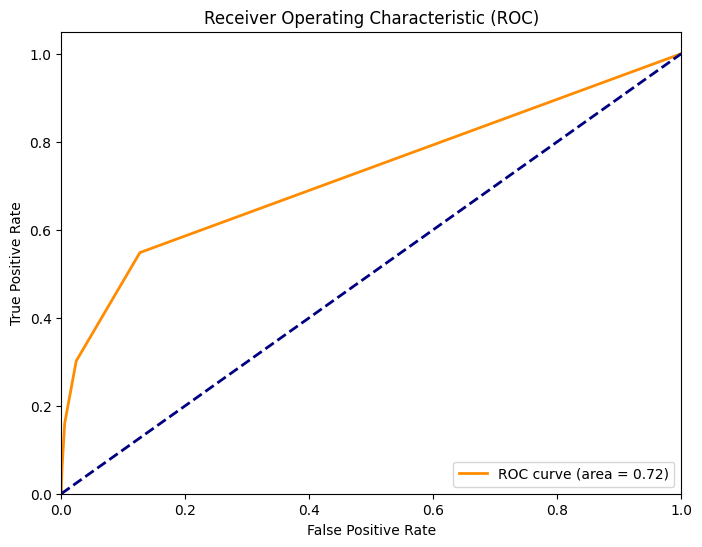

In [59]:
# Identify feature columns (drop non-numeric columns)
features = [
    'dwelling_time_(-1)', 'std_dev_(-1)', 'mean_signal_(-1)',
    'dwelling_time_central', 'std_dev_central', 'mean_signal_central',
    'dwelling_time_(+1)', 'std_dev_(+1)', 'mean_signal_(+1)'
]
# Drop rows with missing values
train.dropna(inplace=True)
test.dropna(inplace=True)

# Prepare feature matrices (X) and target labels (y)
X_train = train[features]
X_test = test[features]
y_train = train['label']
y_test = test['label']

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors as needed
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model with confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Predict probabilities for ROC curve
y_proba = knn.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

